# Working with time series
Time series data are very common in finance and economics. Date and time systems have their own set of rules and logic, which makes them potentially complicated but powerful. Pandas/python has a very powerful set of tools to handle dates and time. We will work through the basics here. As always, the internet if full of the details. 

In this workbook we will cover
1. The datetime data type, which is python's representation of a date and time
2. Setting up a DataFrame to index with datetime objects
3. Changing the frequency of our date, e.g., converting daily data to monthly
4. Plotting time series data
5. Slicing on dates
6. Moving window calculations

### The packages

In [1]:
import pandas as pd               #load the pandas package and call it pd
import matplotlib.pyplot as plt   # load the pyplot set of tools from the package matplotlib. Name it plt for short.
import datetime as dt     # data types and methods for dealing with dates and time. Name it dt for short.

# This following is a jupyter magic command. It tells jupyter to insert the plots into the notebook
# rather than a new window.
%matplotlib inline      

### The datetime type
Python uses the `datetime` type of object to hold date and time data. This allows for very sophisticated handling of time series data. Most of this is beyond the scope of our work, but if you ever find yourself having to deal with time zones or which week of the month a date lies in, datetime has you covered. \[Python was developed to do a lot more than data analysis...\]

We will mostly need to create datatime objects to hold dates. We pass datetime objects to methods that need to know about dates. 

In [2]:
time_1 = dt.datetime(1776, 7, 4)  # year, month, date (datetime will add a time code of 00:00:00)
print('Declare independence on:', time_1)


Declare independence on: 1776-07-04 00:00:00


In [3]:
# We can convert it to different string outputs using the strftime() method. It takes codes as arguments
# and you can format the string however you wish. I added a comma. A list of codes is in table 11-3 of McKinney.

print('Declare independence on:', time_1.strftime('%B %d, %Y'))     # I have no idea why month is 'B'

Declare independence on: July 04, 1776


In [4]:
# We can convert strings to datetime using the same codes. It give us the ability to handle strange formats.

string_date = '1815/1/8'           # What kind of mad man writes dates this way?
time_2 = dt.datetime.strptime(string_date, '%Y/%m/%d')
print('Battle in New Orleans on:', time_2.strftime('%B %d, %Y'))

Battle in New Orleans on: January 08, 1815


We might need some more datetime functionality, but that should be enough for now. 

### The data
The file 'VIXCLSD.csv' contains daily end-of-trading values of the '[VIX](https://finance.yahoo.com/quote/%5EVIX/),' a measure of expected market volatility as implied by S&P 500 options. Business-news types like to refer to it as the 'fear index'. \[That's a bit too dramatic for my tastes, but  those guys have ads to sell.\] The idea is that expected volatility rises when people are worried about the future.  

In [1]:
url = "https://github.com/mwaugh0328/data_bootcamp_spring_2019/raw/master/time_series/VIXCLSD.csv"

vix = pd.read_csv(url, na_values='.')   # There are some missing values marked as '.'
print(vix.head())
print('\n', vix.tail())

NameError: name 'pd' is not defined

The data look about like I would expect. 

In [6]:
print(vix.dtypes)

DATE       object
VIXCLS    float64
dtype: object


What kind of variables do we have? The 'DATE' variable is stored as string right now. Let's convert it to a datetime object.  Let's start by converting the dates and saving them to a new variable so that we can inspect it. 

In [7]:
date_objs = pd.to_datetime(vix['DATE'])
print(date_objs.dtypes)


datetime64[ns]


So the `to_datetime()` conversion creates datetime64\[ns\] objects.  Now let's convert the 'DATE' column to  datetime objects and save it in the DataFrame.

In [8]:
vix['DATE'] = pd.to_datetime(vix['DATE'], yearfirst=True)  # Convert date strings to date time
print( vix.dtypes )
print('\n', vix.head())

DATE      datetime64[ns]
VIXCLS           float64
dtype: object

         DATE  VIXCLS
0 1990-01-02   17.24
1 1990-01-03   18.19
2 1990-01-04   19.22
3 1990-01-05   20.11
4 1990-01-08   20.26


In [9]:
# Now set the index to the dates

vix_di = vix.set_index('DATE')
print(vix_di.index)
print(vix.head())

DatetimeIndex(['1990-01-02', '1990-01-03', '1990-01-04', '1990-01-05',
               '1990-01-08', '1990-01-09', '1990-01-10', '1990-01-11',
               '1990-01-12', '1990-01-15',
               ...
               '2018-09-20', '2018-09-21', '2018-09-24', '2018-09-25',
               '2018-09-26', '2018-09-27', '2018-09-28', '2018-10-01',
               '2018-10-02', '2018-10-03'],
              dtype='datetime64[ns]', name='DATE', length=7502, freq=None)
        DATE  VIXCLS
0 1990-01-02   17.24
1 1990-01-03   18.19
2 1990-01-04   19.22
3 1990-01-05   20.11
4 1990-01-08   20.26


### Changing the frequency
We can *resample* the data to change its frequency. We need to specify how to deal with the vix data. In this case, I want to average it. If we had gdp data, I would want to sum it. 

We are *downsampling* data if we are reducing the number of observations (daily$\rightarrow$monthly) and we are *upsampling* the data if we are increasing the number of observations (monthly$\rightarrow$daily). In my work, I have downsampled a lot. I do not think I have ever upsampled. 

In [10]:
vix_w = vix_di.resample('w').mean()

print(vix_w.index)
print('\n', vix_w.head())


DatetimeIndex(['1990-01-07', '1990-01-14', '1990-01-21', '1990-01-28',
               '1990-02-04', '1990-02-11', '1990-02-18', '1990-02-25',
               '1990-03-04', '1990-03-11',
               ...
               '2018-08-05', '2018-08-12', '2018-08-19', '2018-08-26',
               '2018-09-02', '2018-09-09', '2018-09-16', '2018-09-23',
               '2018-09-30', '2018-10-07'],
              dtype='datetime64[ns]', name='DATE', length=1501, freq='W-SUN')

             VIXCLS
DATE              
1990-01-07  18.690
1990-01-14  21.918
1990-01-21  24.304
1990-01-28  25.744
1990-02-04  25.648


We had 7,502 daily observations. Now we have 1501 weekly observations.  Note the weeks are Sunday-based. Let's downsample some more. 

In [11]:
vix_m = vix_di.resample('m').mean()   # monthly
vix_y = vix_di.resample('y').mean()   # yearly

### Plotting
Now that we have our index set as datetime objects, we can plot the data in sensible ways. In particular, matplotlib can gracefully handle  data at different frequencies.

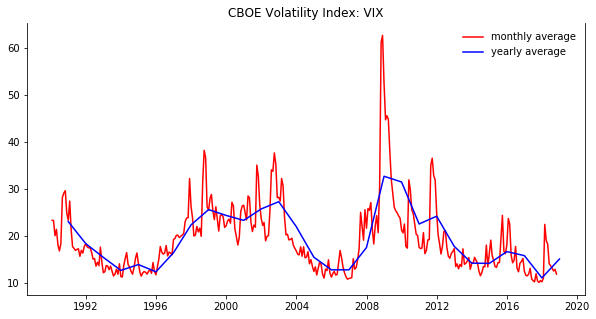

In [12]:
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(vix_m.index, vix_m['VIXCLS'], color = 'red', label = 'monthly average')
ax.plot(vix_y.index, vix_y['VIXCLS'], color = 'blue', label = 'yearly average')

ax.set_title('CBOE Volatility Index: VIX')
ax.spines['top'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.legend(frameon=False)

plt.show()

If we zoom in tight enough, the time axis will relabel in a natural way to reflect the changed time scale. When we refer to coordinates in a time series figure, we pass the x-coordinates as a datetime object. Below, we use datetimes to limit the x-axis and to make some annotations. 

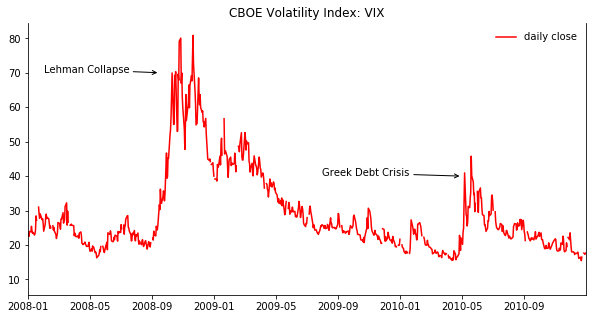

In [13]:
# Any place we need to reference the x axis we use a datetime object.

fig, ax = plt.subplots(figsize=(10,5))
ax.plot(vix_di.index, vix_di['VIXCLS'], color = 'red', label = 'daily close')

ax.set_xlim( dt.datetime(2008,1,1), dt.datetime(2010, 12, 31) ) # The limits need datetime objects

ax.annotate('Lehman Collapse', xy=(dt.datetime(2008,9,15), 70), xytext=(dt.datetime(2008,2,1), 70), 
            arrowprops={'facecolor':'black',  'arrowstyle':'->'}) 

ax.annotate('Greek Debt Crisis', xy=(dt.datetime(2010,5,1), 40), xytext=(dt.datetime(2009,8,1), 40), 
            arrowprops={'facecolor':'black',  'arrowstyle':'->'})

ax.set_title('CBOE Volatility Index: VIX')
ax.spines['top'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.legend(frameon=False)

plt.show()

### Practice: Dates
Take a few minutes and try the following. Feel free to chat with those around if you get stuck. 

1. Read the file 'osk.csv' into a DataFrame. The file contains daily closing prices for OshKosh Corp. and the S&P500. 
2. Set the index to the date. Make sure the dates are datetime objects!


In [14]:
url = "https://raw.githubusercontent.com/mwaugh0328/data_bootcamp_spring_2019/master/time_series/osk.csv"

prices = pd.read_csv(url)
prices['Date']=pd.to_datetime(prices['Date'])
prices.set_index('Date', inplace=True)

prices.head()

,osk,sp500
Date,,
2018-01-02,92.169998,2695.810059
2018-01-03,92.029999,2713.060059
2018-01-04,91.279999,2723.989990
2018-01-05,89.970001,2743.149902
2018-01-08,90.660004,2747.709961


3. Normalize each series by dividing every observation by the value at 01-02-2018. Try 
```python
prices['osk_n'] = prices['osk'] / prices.loc['2018-01-02,','osk']
```
and something similar to the S&P500.

In [15]:
prices['osk_n'] = prices['osk'] / prices.loc['2018-01-02,','osk']
prices['sp500_n'] = prices['sp500'] / prices.loc['2018-01-02,','sp500']
prices.head()

,osk,sp500,osk_n,sp500_n
Date,,,,
2018-01-02,92.169998,2695.810059,1.000000,1.000000
2018-01-03,92.029999,2713.060059,0.998481,1.006399
2018-01-04,91.279999,2723.989990,0.990344,1.010453
2018-01-05,89.970001,2743.149902,0.976131,1.017561
2018-01-08,90.660004,2747.709961,0.983617,1.019252


4. Plot the two normalized series

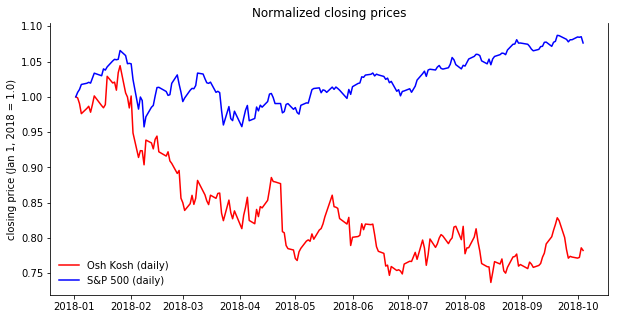

In [16]:
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(prices.index, prices['osk_n'], color = 'red', label = 'Osh Kosh (daily)', alpha = 1)
ax.plot(prices.index, prices['sp500_n'], color = 'blue', label = 'S&P 500 (daily)', alpha = 1)


#ax.set_xlim( datetime(2008,1,1), datetime(2010, 12, 31) ) # The limits need datetime objects
ax.set_ylabel('closing price (Jan 1, 2018 = 1.0)')
ax.set_title('Normalized closing prices')
ax.spines['top'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.legend(frameon=False)

plt.show()

5. Resample the data to a weekly frequency creating average weekly prices. (I would recommend creating a new DataFrame)
6. Create new indexes, normalizing by the first week of the year.
7. Add the weekly data to your figure from part 4. Use the alpha parameter to lighten up the daily data lines. 
8. How does your plot look? Are the titles correct? Is there a legend or some other way of identifying the lines?

In [17]:
prices_w = prices[['osk', 'sp500']].resample('w').mean()
prices_w['osk_n'] = prices_w['osk'] / prices_w.loc['2018-01-07,','osk']
prices_w['sp500_n'] = prices_w['sp500'] / prices_w.loc['2018-01-07,','sp500']
prices_w.head()

,osk,sp500,osk_n,sp500_n
Date,,,,
2018-01-07,91.362499,2719.002502,1.000000,1.000000
2018-01-14,91.040003,2760.206006,0.996470,1.015154
2018-01-21,91.939999,2796.827515,1.006321,1.028623
2018-01-28,94.536000,2844.352002,1.034735,1.046101
2018-02-04,91.056000,2816.775977,0.996645,1.035959


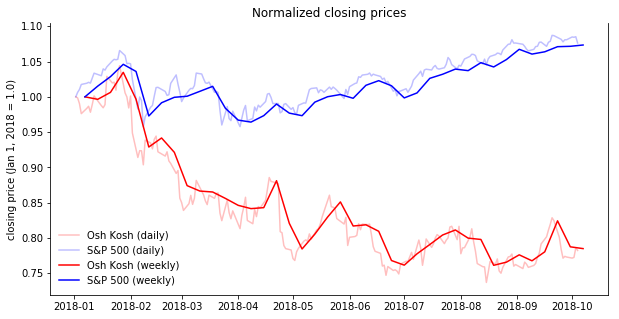

In [18]:
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(prices.index, prices['osk_n'], color = 'red', label = 'Osh Kosh (daily)', alpha = 0.25)
ax.plot(prices.index, prices['sp500_n'], color = 'blue', label = 'S&P 500 (daily)', alpha = 0.25)

ax.plot(prices_w.index, prices_w['osk_n'], color = 'red', label = 'Osh Kosh (weekly)')
ax.plot(prices_w.index, prices_w['sp500_n'], color = 'blue', label = 'S&P 500 (weekly)')

#ax.set_xlim( datetime(2008,1,1), datetime(2010, 12, 31) ) # The limits need datetime objects
ax.set_ylabel('closing price (Jan 1, 2018 = 1.0)')
ax.set_title('Normalized closing prices')
ax.spines['top'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.legend(frameon=False)

plt.show()

### Slicing with dates
An alternative way to 'zoom in' on the data is to plot a slice of the DataFrame. With an index of datetime, this is surprisingly easy. 


In [19]:
# Option 1: create a datetime and pass it
date_to_extract = dt.datetime(2008, 6, 18)  # create a datetime with the day I want
print('The vix on', date_to_extract.strftime('%B %d, %Y'), 'is', vix_di.loc[date_to_extract, 'VIXCLS'] )   # extract with with loc[], like usual

# Option 2: Query directly with a string
print('The vix on June 18, 2008 is', vix_di.loc['2008-06-18', 'VIXCLS'])


The vix on June 18, 2008 is 22.24
The vix on June 18, 2008 is 22.24


We can slice, too:
1. We can grab every observation with a year of 2008 with '2008'.
2. We can grab every observation between Jan 1, 2008 and Jan 31, 2008 by slicing with '2008/01/01':'2008/01/31'. Python is smart enough to understand references to dates that are not in the DataFrame. There is no January 1 or January 31 observation.

In [20]:
print('Every week in 2008:', vix_w.loc['2008'])  # all the weeks in 2008
print('\nEvery week in Jan 2008:', vix_w.loc['2008/01/01':'2008/01/31']) # all the weeks in January 2008

Every week in 2008:              VIXCLS
DATE               
2008-01-06  23.0250
2008-01-13  24.0940
2008-01-20  25.2520
2008-01-27  29.2225
2008-02-03  26.5880
2008-02-10  27.7740
2008-02-17  25.8740
2008-02-24  24.7925
2008-03-02  23.5380
2008-03-09  26.2880
2008-03-16  28.2820
2008-03-23  28.6225
2008-03-30  25.8240
2008-04-06  23.4760
2008-04-13  22.6060
2008-04-20  21.5260
2008-04-27  20.2560
2008-05-04  19.5460
2008-05-11  19.1300
2008-05-18  17.2400
2008-05-25  18.1560
2008-06-01  18.6700
2008-06-08  20.6120
2008-06-15  22.9940
2008-06-22  21.7540
2008-06-29  22.7140
2008-07-06  24.5750
2008-07-13  25.4480
2008-07-20  26.2360
2008-07-27  22.3780
2008-08-03  22.5960
2008-08-10  21.3340
2008-08-17  20.5520
2008-08-24  20.2620
2008-08-31  20.2600
2008-09-07  22.6275
2008-09-14  24.5360
2008-09-21  32.6780
2008-09-28  34.4640
2008-10-05  43.2640
2008-10-12  59.4260
2008-10-19  63.4620
2008-10-26  64.5320
2008-11-02  67.9540
2008-11-09  55.1500
2008-11-16  62.8040
2008-11-23  72.9160


### Rolling window calculations
The `rolling()` method of DataFrame allows methods like mean() and var() to be calculated over a rolling window of the data.  We often use moving averages to extract trends from noisy data. 

Calling 
```python
vix_di['VIXCLS'].rolling(60)
```
generates a Series of rolling observations. In this case, I am asking for a 60-day window. We can directly call a method like `mean()` or `var()` to compute rolling calculations. 
```python
vix_di['VIXCLS'].rolling(60).mean()
```
Notice in the code below that I have to strip out the missing values using `dropna()`. Otherwise, `rolling()` will only work on the complete 60-day windows.



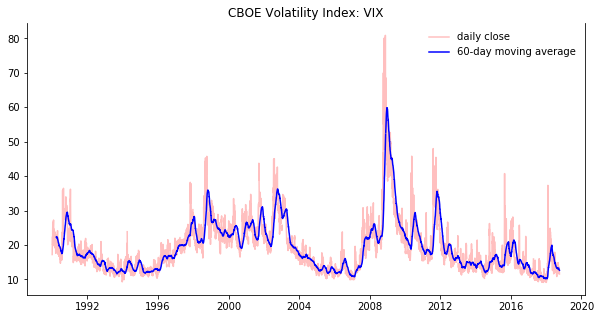

In [21]:
vix_di['vix_ma'] = vix_di['VIXCLS'].dropna().rolling(60).mean()                             # create the moving average


fig, ax = plt.subplots(figsize=(10,5))
ax.plot(vix_di.index, vix_di['VIXCLS'], color = 'red', label = 'daily close', alpha=0.25)
ax.plot(vix_di.index, vix_di['vix_ma'], color = 'blue', label = '60-day moving average')

ax.set_title('CBOE Volatility Index: VIX')
ax.spines['top'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.legend(frameon=False)

plt.show()

### Practice: Dates
Take a few minutes and try the following. Feel free to chat with those around if you get stuck. The TA and I are here, too.

1. Compute and plot the 30-day rolling standard deviation of the Osh Kosh and S&P 500 normalized daily prices.


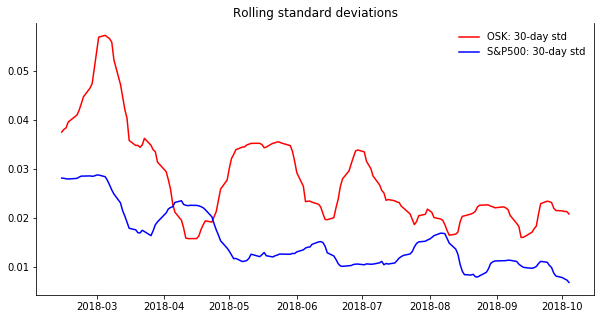

In [22]:
prices['std_osk'] = prices['osk_n'].rolling(30).std()
prices['std_sp500'] = prices['sp500_n'].rolling(30).std()

fig, ax = plt.subplots(figsize=(10,5))
ax.plot(prices.index, prices['std_osk'], color = 'red', label = 'OSK: 30-day std')
ax.plot(prices.index, prices['std_sp500'], color = 'blue', label = 'S&P500: 30-day std')


ax.set_title('Rolling standard deviations')
ax.spines['top'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.legend(frameon=False)

plt.show()

2. Plot only the standard deviation for the first half of the year. Use a slice on the index to do it. \[You could also try the `truncate()` method.\] 

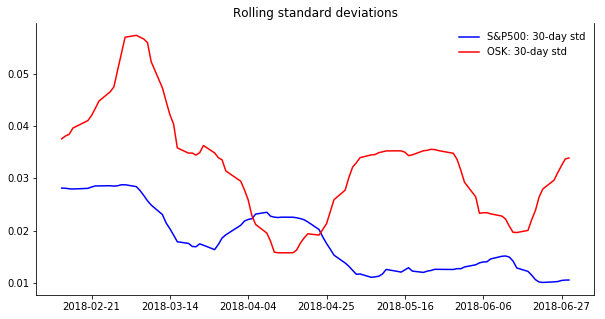

In [23]:
fig, ax = plt.subplots(figsize=(10,5))

# With a slice
ax.plot(prices['std_sp500'].loc['01-01-2018':'06-30-2018'], color = 'blue', label = 'S&P500: 30-day std')

# With truncate()
ax.plot(prices['std_osk'].truncate(after='06-30-2018'), color = 'red', label = 'OSK: 30-day std')


ax.set_title('Rolling standard deviations')
ax.spines['top'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.legend(frameon=False)

plt.show()